# SPEED
## speed tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from models import *
from data_loader import *
from data_format import *
from datapath import *
from IPython.display import clear_output
import scipy.stats as stats
import seaborn as sns
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")
csfont = {'fontname':'Times New Roman'}
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
#


Using device: cuda
Using device: cuda
Using device: cuda


## create dataset

In [8]:
#get varying sizes of the dataset
"""data=loaded(t=-1,filename="X_data_15.npz")
data.applySobel()
data.orientation_augment()
data.speed_augment(4,speeds=3)
data.zoom_augment([10,20,30,40])"""

'data=loaded(t=-1,filename="X_data_15.npz")\ndata.applySobel()\ndata.orientation_augment()\ndata.speed_augment(4,speeds=3)\ndata.zoom_augment([10,20,30,40])'

## experiments

In [2]:
#global parameters
test_data=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/texture-tactip/concatenated_data_handheld.npy").astype(np.uint8)
labels=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/texture-tactip/concatenated_labels_handheld.npy").astype(np.uint8)
test_data_sliced=test_data[:,::4,:,:]
test_data_sliced=test_data_sliced[:,10:10+4,:,:]
crop=[60,180,40,150]
im=test_data_sliced[:,:,crop[2]:crop[3],crop[0]:crop[1]]
new=np.zeros((im.shape[0],im.shape[1],im.shape[2],im.shape[3]))
for i in range(len(test_data_sliced)): #crop all images individually
    for j in range(len(test_data_sliced[0])):
        image=cv2.resize(test_data_sliced[i][j],(int(640*0.4),int(480*0.4)),interpolation=cv2.INTER_AREA)
        image=cv2.cvtColor(image[crop[2]:crop[3],crop[0]:crop[1]], cv2.COLOR_BGR2GRAY)
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        new[i][j]=sobel_combined
print(new.shape)
new=new.reshape(new.shape[0],1,4*new.shape[2],new.shape[3])
print(new.shape)
new=(new-np.mean(new))/(np.max(new)-np.min(new))
test_data_sliced_tensor=torch.tensor(new,dtype=torch.float64).float().to(device)


def calc_noisy(preds,labels):
    names=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'jeans', 'Leather']
    the_other_labels=['Cork','FoamF','FoamG','LacedMatt','Leather','LongCarpet','Plastic','ShortCarpet','Bubble','FoamE']
    mapping={0:7,1:3,3:0,5:5,7:6,9:1,10:2,11:8,12:9,14:4}
    classes=torch.argmax(preds,axis=1)
    correct=0
    for i in range(len(classes)):
        if mapping.get(classes[i],-1) >0:
            if mapping[classes[i]]==labels[i]: correct+=1
    return correct/len(classes) *100

num_trials=20
T_SIZE=4
EPOCHS=100

(50, 4, 110, 120)
(50, 1, 440, 120)


### experiment with different zooms

In [33]:
## zoom experiments
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=T_SIZE,filename="X_data_15.npz")
    data.applySobel()
    data.zoom_augment([10,20,30,40])
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_ZOOM_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.6819
Epoch [11/100], Step [240/240], Loss: 59.8269
Epoch [21/100], Step [240/240], Loss: 8.3617
Epoch [31/100], Step [240/240], Loss: 1.2514
Epoch [41/100], Step [240/240], Loss: 0.4467
Epoch [51/100], Step [240/240], Loss: 0.2775
Epoch [61/100], Step [240/240], Loss: 0.1973
Epoch [71/100], Step [240/240], Loss: 0.1437
Epoch [81/100], Step [240/240], Loss: 0.1166
Epoch [91/100], Step [240/240], Loss: 0.0974
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.2054
Epoch [11/100], Step [240/240], Loss: 45.1367
Epoch [21/100], Step [240/240], Loss: 5.7885
Epoch [31/100], Step [240/240], Loss: 0.9357
Epoch [41/100], Step [240/240], Loss: 0.3970
Epoch [51/100], Step [240/240], Loss: 0.4021
Epoch [61/100], Step [240/240], Loss: 0.1803
Epoch [71/100], Step [240/240], Loss: 0.1403
Epoch [81/100], Step [240/240], Loss: 0.1107
Epoch [91/100], Step [240/240], Loss: 0.0954
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.1236
Epoch [11/100], Step [240/240], Loss: 51.9659
Epoch [21/100], Step [240/240], Loss: 5.9069
Epoch [31/100], Step [240/240], Loss: 1.0731
Epoch [41/100], Step [240/240], Loss: 0.4982
Epoch [51/100], Step [240/240], Loss: 0.2706
Epoch [61/100], Step [240/240], Loss: 0.1816
Epoch [71/100], Step [240/240], Loss: 0.1390
Epoch [81/100], Step [240/240], Loss: 0.1128
Epoch [91/100], Step [240/240], Loss: 0.0945
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.6384
Epoch [11/100], Step [240/240], Loss: 52.1720
Epoch [21/100], Step [240/240], Loss: 6.4097
Epoch [31/100], Step [240/240], Loss: 1.5891
Epoch [41/100], Step [240/240], Loss: 0.4893
Epoch [51/100], Step [240/240], Loss: 0.2931
Epoch [61/100], Step [240/240], Loss: 0.1967
Epoch [71/100], Step [240/240], Loss: 0.1423
Epoch [81/100], Step [240/240], Loss: 0.1168
Epoch [91/100], Step [240/240], Loss: 0.0997
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 648.9594
Epoch [11/100], Step [240/240], Loss: 45.5458
Epoch [21/100], Step [240/240], Loss: 5.5336
Epoch [31/100], Step [240/240], Loss: 1.0707
Epoch [41/100], Step [240/240], Loss: 0.5750
Epoch [51/100], Step [240/240], Loss: 0.2591
Epoch [61/100], Step [240/240], Loss: 0.1769
Epoch [71/100], Step [240/240], Loss: 0.1341
Epoch [81/100], Step [240/240], Loss: 0.1109
Epoch [91/100], Step [240/240], Loss: 0.0912
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 650.0478
Epoch [11/100], Step [240/240], Loss: 158.9492
Epoch [21/100], Step [240/240], Loss: 17.9433
Epoch [31/100], Step [240/240], Loss: 2.2205
Epoch [41/100], Step [240/240], Loss: 0.8953
Epoch [51/100], Step [240/240], Loss: 0.3194
Epoch [61/100], Step [240/240], Loss: 0.2306
Epoch [71/100], Step [240/240], Loss: 0.1672
Epoch [81/100], Step [240/240], Loss: 0.1254
Epoch [91/100], Step [240/240], Loss: 0.1072
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.7966
Epoch [11/100], Step [240/240], Loss: 55.3954
Epoch [21/100], Step [240/240], Loss: 6.9828
Epoch [31/100], Step [240/240], Loss: 1.5502
Epoch [41/100], Step [240/240], Loss: 0.4392
Epoch [51/100], Step [240/240], Loss: 0.2677
Epoch [61/100], Step [240/240], Loss: 0.3247
Epoch [71/100], Step [240/240], Loss: 0.1504
Epoch [81/100], Step [240/240], Loss: 0.1207
Epoch [91/100], Step [240/240], Loss: 0.0990
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.5968
Epoch [11/100], Step [240/240], Loss: 58.7178
Epoch [21/100], Step [240/240], Loss: 7.5321
Epoch [31/100], Step [240/240], Loss: 2.1226
Epoch [41/100], Step [240/240], Loss: 0.4870
Epoch [51/100], Step [240/240], Loss: 0.2935
Epoch [61/100], Step [240/240], Loss: 0.1896
Epoch [71/100], Step [240/240], Loss: 0.1533
Epoch [81/100], Step [240/240], Loss: 0.1147
Epoch [91/100], Step [240/240], Loss: 0.0939
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.5470
Epoch [11/100], Step [240/240], Loss: 54.8962
Epoch [21/100], Step [240/240], Loss: 7.0218
Epoch [31/100], Step [240/240], Loss: 1.3944
Epoch [41/100], Step [240/240], Loss: 0.4625
Epoch [51/100], Step [240/240], Loss: 0.2529
Epoch [61/100], Step [240/240], Loss: 0.1882
Epoch [71/100], Step [240/240], Loss: 0.1370
Epoch [81/100], Step [240/240], Loss: 0.1101
Epoch [91/100], Step [240/240], Loss: 0.0917
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.91250364568144 %
Results: [0.99998958 0.99912504 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.3295
Epoch [11/100], Step [240/240], Loss: 85.9964
Epoch [21/100], Step [240/240], Loss: 13.0380
Epoch [31/100], Step [240/240], Loss: 2.0692
Epoch [41/100], Step [240/240], Loss: 0.4991
Epoch [51/100], Step [240/240], Loss: 0.2927
Epoch [61/100], Step [240/240], Loss: 0.2048
Epoch [71/100], Step [240/240], Loss: 0.1532
Epoch [81/100], Step [240/240], Loss: 0.1189
Epoch [91/100], Step [240/240], Loss: 0.1000
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 650.0274
Epoch [11/100], Step [240/240], Loss: 113.1840
Epoch [21/100], Step [240/240], Loss: 13.5729
Epoch [31/100], Step [240/240], Loss: 2.5065
Epoch [41/100], Step [240/240], Loss: 0.7168
Epoch [51/100], Step [240/240], Loss: 0.3602
Epoch [61/100], Step [240/240], Loss: 0.2660
Epoch [71/100], Step [240/240], Loss: 0.1637
Epoch [81/100], Step [240/240], Loss: 0.1484
Epoch [91/100], Step [240/240], Loss: 0.1024
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 650.0117
Epoch [11/100], Step [240/240], Loss: 84.1284
Epoch [21/100], Step [240/240], Loss: 11.4754
Epoch [31/100], Step [240/240], Loss: 1.6502
Epoch [41/100], Step [240/240], Loss: 0.5540
Epoch [51/100], Step [240/240], Loss: 0.2885
Epoch [61/100], Step [240/240], Loss: 0.2026
Epoch [71/100], Step [240/240], Loss: 0.1494
Epoch [81/100], Step [240/240], Loss: 0.1220
Epoch [91/100], Step [240/240], Loss: 0.0971
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.4528
Epoch [11/100], Step [240/240], Loss: 59.1085
Epoch [21/100], Step [240/240], Loss: 7.8382
Epoch [31/100], Step [240/240], Loss: 1.3677
Epoch [41/100], Step [240/240], Loss: 0.4861
Epoch [51/100], Step [240/240], Loss: 0.3125
Epoch [61/100], Step [240/240], Loss: 0.2728
Epoch [71/100], Step [240/240], Loss: 0.1445
Epoch [81/100], Step [240/240], Loss: 0.1167
Epoch [91/100], Step [240/240], Loss: 0.0970
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.9914
Epoch [11/100], Step [240/240], Loss: 78.0525
Epoch [21/100], Step [240/240], Loss: 9.2075
Epoch [31/100], Step [240/240], Loss: 1.7504
Epoch [41/100], Step [240/240], Loss: 0.5884
Epoch [51/100], Step [240/240], Loss: 0.3512
Epoch [61/100], Step [240/240], Loss: 0.2022
Epoch [71/100], Step [240/240], Loss: 0.1530
Epoch [81/100], Step [240/240], Loss: 0.1229
Epoch [91/100], Step [240/240], Loss: 0.0996
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.8565
Epoch [11/100], Step [240/240], Loss: 63.8338
Epoch [21/100], Step [240/240], Loss: 7.9341
Epoch [31/100], Step [240/240], Loss: 1.6508
Epoch [41/100], Step [240/240], Loss: 0.4401
Epoch [51/100], Step [240/240], Loss: 0.2665
Epoch [61/100], Step [240/240], Loss: 0.1880
Epoch [71/100], Step [240/240], Loss: 0.1458
Epoch [81/100], Step [240/240], Loss: 0.1180
Epoch [91/100], Step [240/240], Loss: 0.0959
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.1767
Epoch [11/100], Step [240/240], Loss: 52.9127
Epoch [21/100], Step [240/240], Loss: 7.0230
Epoch [31/100], Step [240/240], Loss: 1.4967
Epoch [41/100], Step [240/240], Loss: 0.4656
Epoch [51/100], Step [240/240], Loss: 0.2469
Epoch [61/100], Step [240/240], Loss: 0.1804
Epoch [71/100], Step [240/240], Loss: 0.1360
Epoch [81/100], Step [240/240], Loss: 0.1103
Epoch [91/100], Step [240/240], Loss: 0.0892
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.5387
Epoch [11/100], Step [240/240], Loss: 51.7895
Epoch [21/100], Step [240/240], Loss: 6.3138
Epoch [31/100], Step [240/240], Loss: 1.4068
Epoch [41/100], Step [240/240], Loss: 0.5794
Epoch [51/100], Step [240/240], Loss: 0.2729
Epoch [61/100], Step [240/240], Loss: 0.1897
Epoch [71/100], Step [240/240], Loss: 0.1446
Epoch [81/100], Step [240/240], Loss: 0.1187
Epoch [91/100], Step [240/240], Loss: 0.0942
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.8307
Epoch [11/100], Step [240/240], Loss: 72.6349
Epoch [21/100], Step [240/240], Loss: 9.5912
Epoch [31/100], Step [240/240], Loss: 1.8763
Epoch [41/100], Step [240/240], Loss: 0.4753
Epoch [51/100], Step [240/240], Loss: 0.2784
Epoch [61/100], Step [240/240], Loss: 0.1996
Epoch [71/100], Step [240/240], Loss: 0.1424
Epoch [81/100], Step [240/240], Loss: 0.1143
Epoch [91/100], Step [240/240], Loss: 0.0951
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.0149
Epoch [11/100], Step [240/240], Loss: 50.3929
Epoch [21/100], Step [240/240], Loss: 6.4122
Epoch [31/100], Step [240/240], Loss: 1.0203
Epoch [41/100], Step [240/240], Loss: 0.5424
Epoch [51/100], Step [240/240], Loss: 0.2784
Epoch [61/100], Step [240/240], Loss: 0.1961
Epoch [71/100], Step [240/240], Loss: 0.1393
Epoch [81/100], Step [240/240], Loss: 0.1156
Epoch [91/100], Step [240/240], Loss: 0.0930
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(12000, 4, 110, 120) (12000, 1, 440, 120)
Using 4.72 GB
torch.Size([12000, 1, 440, 120])
torch.Size([12000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [240/240], Loss: 649.6578
Epoch [11/100], Step [240/240], Loss: 61.2825
Epoch [21/100], Step [240/240], Loss: 7.5931
Epoch [31/100], Step [240/240], Loss: 1.4401
Epoch [41/100], Step [240/240], Loss: 0.6029
Epoch [51/100], Step [240/240], Loss: 0.3157
Epoch [61/100], Step [240/240], Loss: 0.2003
Epoch [71/100], Step [240/240], Loss: 0.1584
Epoch [81/100], Step [240/240], Loss: 0.1175
Epoch [91/100], Step [240/240], Loss: 0.0973
Finished Training
Commence calculations...
Accuracy: 99.9989583441839 %
Accuracy: 99.99583350693722 %
Results: [0.99998958 0.99995834 0.        ]


### experiment with different speeds

In [34]:
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=-1,filename="X_data_15.npz")
    data.applySobel()
    data.speed_augment(t=4)
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_SPEED_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 484.8174
Epoch [11/100], Step [180/180], Loss: 21.6758
Epoch [21/100], Step [180/180], Loss: 0.8357
Epoch [31/100], Step [180/180], Loss: 0.3974
Epoch [41/100], Step [180/180], Loss: 0.1601
Epoch [51/100], Step [180/180], Loss: 0.1132
Epoch [61/100], Step [180/180], Loss: 0.0844
Epoch [71/100], Step [180/180], Loss: 0.0661
Epoch [81/100], Step [180/180], Loss: 0.0539
Epoch [91/100], Step [180/180], Loss: 0.0460
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 484.7044
Epoch [11/100], Step [180/180], Loss: 21.6222
Epoch [21/100], Step [180/180], Loss: 0.8060
Epoch [31/100], Step [180/180], Loss: 0.2877
Epoch [41/100], Step [180/180], Loss: 0.1665
Epoch [51/100], Step [180/180], Loss: 0.1149
Epoch [61/100], Step [180/180], Loss: 0.0842
Epoch [71/100], Step [180/180], Loss: 0.0671
Epoch [81/100], Step [180/180], Loss: 0.0544
Epoch [91/100], Step [180/180], Loss: 0.0457
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 481.4828
Epoch [11/100], Step [180/180], Loss: 17.0868
Epoch [21/100], Step [180/180], Loss: 1.0621
Epoch [31/100], Step [180/180], Loss: 0.2748
Epoch [41/100], Step [180/180], Loss: 0.1650
Epoch [51/100], Step [180/180], Loss: 0.1151
Epoch [61/100], Step [180/180], Loss: 0.0865
Epoch [71/100], Step [180/180], Loss: 0.0687
Epoch [81/100], Step [180/180], Loss: 0.0562
Epoch [91/100], Step [180/180], Loss: 0.0480
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.2535
Epoch [11/100], Step [180/180], Loss: 23.5172
Epoch [21/100], Step [180/180], Loss: 1.0294
Epoch [31/100], Step [180/180], Loss: 0.2941
Epoch [41/100], Step [180/180], Loss: 0.1697
Epoch [51/100], Step [180/180], Loss: 0.1162
Epoch [61/100], Step [180/180], Loss: 0.0870
Epoch [71/100], Step [180/180], Loss: 0.0684
Epoch [81/100], Step [180/180], Loss: 0.0553
Epoch [91/100], Step [180/180], Loss: 0.0467
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 484.7550
Epoch [11/100], Step [180/180], Loss: 21.0897
Epoch [21/100], Step [180/180], Loss: 0.9017
Epoch [31/100], Step [180/180], Loss: 0.2907
Epoch [41/100], Step [180/180], Loss: 0.1656
Epoch [51/100], Step [180/180], Loss: 0.1142
Epoch [61/100], Step [180/180], Loss: 0.0852
Epoch [71/100], Step [180/180], Loss: 0.0680
Epoch [81/100], Step [180/180], Loss: 0.0557
Epoch [91/100], Step [180/180], Loss: 0.0463
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 482.3908
Epoch [11/100], Step [180/180], Loss: 17.5255
Epoch [21/100], Step [180/180], Loss: 0.7970
Epoch [31/100], Step [180/180], Loss: 0.2800
Epoch [41/100], Step [180/180], Loss: 0.1642
Epoch [51/100], Step [180/180], Loss: 0.1132
Epoch [61/100], Step [180/180], Loss: 0.0854
Epoch [71/100], Step [180/180], Loss: 0.0673
Epoch [81/100], Step [180/180], Loss: 0.0550
Epoch [91/100], Step [180/180], Loss: 0.0468
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 478.0914
Epoch [11/100], Step [180/180], Loss: 13.2674
Epoch [21/100], Step [180/180], Loss: 0.6587
Epoch [31/100], Step [180/180], Loss: 0.2609
Epoch [41/100], Step [180/180], Loss: 0.1533
Epoch [51/100], Step [180/180], Loss: 0.1091
Epoch [61/100], Step [180/180], Loss: 0.0813
Epoch [71/100], Step [180/180], Loss: 0.0645
Epoch [81/100], Step [180/180], Loss: 0.0536
Epoch [91/100], Step [180/180], Loss: 0.0453
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.0420
Epoch [11/100], Step [180/180], Loss: 23.2780
Epoch [21/100], Step [180/180], Loss: 0.9499
Epoch [31/100], Step [180/180], Loss: 0.2991
Epoch [41/100], Step [180/180], Loss: 0.1691
Epoch [51/100], Step [180/180], Loss: 0.1156
Epoch [61/100], Step [180/180], Loss: 0.0869
Epoch [71/100], Step [180/180], Loss: 0.0679
Epoch [81/100], Step [180/180], Loss: 0.0567
Epoch [91/100], Step [180/180], Loss: 0.0475
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 484.3364
Epoch [11/100], Step [180/180], Loss: 18.7001
Epoch [21/100], Step [180/180], Loss: 0.9906
Epoch [31/100], Step [180/180], Loss: 0.2719
Epoch [41/100], Step [180/180], Loss: 0.1640
Epoch [51/100], Step [180/180], Loss: 0.1122
Epoch [61/100], Step [180/180], Loss: 0.0831
Epoch [71/100], Step [180/180], Loss: 0.0662
Epoch [81/100], Step [180/180], Loss: 0.0544
Epoch [91/100], Step [180/180], Loss: 0.0459
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 483.2304
Epoch [11/100], Step [180/180], Loss: 20.0169
Epoch [21/100], Step [180/180], Loss: 0.7522
Epoch [31/100], Step [180/180], Loss: 0.2821
Epoch [41/100], Step [180/180], Loss: 0.1685
Epoch [51/100], Step [180/180], Loss: 0.1146
Epoch [61/100], Step [180/180], Loss: 0.0853
Epoch [71/100], Step [180/180], Loss: 0.0684
Epoch [81/100], Step [180/180], Loss: 0.0561
Epoch [91/100], Step [180/180], Loss: 0.0470
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 480.2541
Epoch [11/100], Step [180/180], Loss: 17.7426
Epoch [21/100], Step [180/180], Loss: 0.7502
Epoch [31/100], Step [180/180], Loss: 0.2716
Epoch [41/100], Step [180/180], Loss: 0.1586
Epoch [51/100], Step [180/180], Loss: 0.1116
Epoch [61/100], Step [180/180], Loss: 0.0839
Epoch [71/100], Step [180/180], Loss: 0.0656
Epoch [81/100], Step [180/180], Loss: 0.0546
Epoch [91/100], Step [180/180], Loss: 0.0450
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 482.8980
Epoch [11/100], Step [180/180], Loss: 23.1070
Epoch [21/100], Step [180/180], Loss: 1.2570
Epoch [31/100], Step [180/180], Loss: 0.3083
Epoch [41/100], Step [180/180], Loss: 0.1734
Epoch [51/100], Step [180/180], Loss: 0.1166
Epoch [61/100], Step [180/180], Loss: 0.0859
Epoch [71/100], Step [180/180], Loss: 0.0674
Epoch [81/100], Step [180/180], Loss: 0.0552
Epoch [91/100], Step [180/180], Loss: 0.0469
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.9488
Epoch [11/100], Step [180/180], Loss: 20.1292
Epoch [21/100], Step [180/180], Loss: 0.7768
Epoch [31/100], Step [180/180], Loss: 0.2855
Epoch [41/100], Step [180/180], Loss: 0.1652
Epoch [51/100], Step [180/180], Loss: 0.1134
Epoch [61/100], Step [180/180], Loss: 0.0851
Epoch [71/100], Step [180/180], Loss: 0.0677
Epoch [81/100], Step [180/180], Loss: 0.0555
Epoch [91/100], Step [180/180], Loss: 0.0465
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 482.5981
Epoch [11/100], Step [180/180], Loss: 21.4459
Epoch [21/100], Step [180/180], Loss: 1.0806
Epoch [31/100], Step [180/180], Loss: 0.2878
Epoch [41/100], Step [180/180], Loss: 0.1641
Epoch [51/100], Step [180/180], Loss: 0.1125
Epoch [61/100], Step [180/180], Loss: 0.0834
Epoch [71/100], Step [180/180], Loss: 0.0666
Epoch [81/100], Step [180/180], Loss: 0.0543
Epoch [91/100], Step [180/180], Loss: 0.0456
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.5712
Epoch [11/100], Step [180/180], Loss: 19.4542
Epoch [21/100], Step [180/180], Loss: 1.1460
Epoch [31/100], Step [180/180], Loss: 0.2746
Epoch [41/100], Step [180/180], Loss: 0.1603
Epoch [51/100], Step [180/180], Loss: 0.1097
Epoch [61/100], Step [180/180], Loss: 0.0825
Epoch [71/100], Step [180/180], Loss: 0.0659
Epoch [81/100], Step [180/180], Loss: 0.0539
Epoch [91/100], Step [180/180], Loss: 0.0460
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 483.1525
Epoch [11/100], Step [180/180], Loss: 20.1786
Epoch [21/100], Step [180/180], Loss: 1.4434
Epoch [31/100], Step [180/180], Loss: 0.2799
Epoch [41/100], Step [180/180], Loss: 0.1654
Epoch [51/100], Step [180/180], Loss: 0.1096
Epoch [61/100], Step [180/180], Loss: 0.0835
Epoch [71/100], Step [180/180], Loss: 0.0664
Epoch [81/100], Step [180/180], Loss: 0.0543
Epoch [91/100], Step [180/180], Loss: 0.0458
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 479.9876
Epoch [11/100], Step [180/180], Loss: 19.4453
Epoch [21/100], Step [180/180], Loss: 1.1091
Epoch [31/100], Step [180/180], Loss: 0.2883
Epoch [41/100], Step [180/180], Loss: 0.1677
Epoch [51/100], Step [180/180], Loss: 0.1136
Epoch [61/100], Step [180/180], Loss: 0.0842
Epoch [71/100], Step [180/180], Loss: 0.0673
Epoch [81/100], Step [180/180], Loss: 0.0551
Epoch [91/100], Step [180/180], Loss: 0.0459
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 484.0479
Epoch [11/100], Step [180/180], Loss: 18.8798
Epoch [21/100], Step [180/180], Loss: 0.7507
Epoch [31/100], Step [180/180], Loss: 0.2790
Epoch [41/100], Step [180/180], Loss: 0.1623
Epoch [51/100], Step [180/180], Loss: 0.1114
Epoch [61/100], Step [180/180], Loss: 0.0834
Epoch [71/100], Step [180/180], Loss: 0.0660
Epoch [81/100], Step [180/180], Loss: 0.0534
Epoch [91/100], Step [180/180], Loss: 0.0459
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 482.5832
Epoch [11/100], Step [180/180], Loss: 14.8216
Epoch [21/100], Step [180/180], Loss: 0.7285
Epoch [31/100], Step [180/180], Loss: 0.2812
Epoch [41/100], Step [180/180], Loss: 0.1635
Epoch [51/100], Step [180/180], Loss: 0.1149
Epoch [61/100], Step [180/180], Loss: 0.0873
Epoch [71/100], Step [180/180], Loss: 0.0696
Epoch [81/100], Step [180/180], Loss: 0.0563
Epoch [91/100], Step [180/180], Loss: 0.0481
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.3085
Epoch [11/100], Step [180/180], Loss: 22.3345
Epoch [21/100], Step [180/180], Loss: 1.0248
Epoch [31/100], Step [180/180], Loss: 0.2992
Epoch [41/100], Step [180/180], Loss: 0.1711
Epoch [51/100], Step [180/180], Loss: 0.1142
Epoch [61/100], Step [180/180], Loss: 0.0875
Epoch [71/100], Step [180/180], Loss: 0.0684
Epoch [81/100], Step [180/180], Loss: 0.0558
Epoch [91/100], Step [180/180], Loss: 0.0473
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]


### orientation augment

In [35]:
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=T_SIZE,filename="X_data_15.npz")
    data.applySobel()
    data.orientation_augment()
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_ORIENTATION_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.0839
Epoch [11/100], Step [180/180], Loss: 91.8348
Epoch [21/100], Step [180/180], Loss: 25.3555
Epoch [31/100], Step [180/180], Loss: 9.0112
Epoch [41/100], Step [180/180], Loss: 1.1415
Epoch [51/100], Step [180/180], Loss: 0.4179
Epoch [61/100], Step [180/180], Loss: 0.1716
Epoch [71/100], Step [180/180], Loss: 0.1213
Epoch [81/100], Step [180/180], Loss: 0.0936
Epoch [91/100], Step [180/180], Loss: 0.0774
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.93889228376202 %
Results: [0.99998611 0.99938892 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.9933
Epoch [11/100], Step [180/180], Loss: 95.8828
Epoch [21/100], Step [180/180], Loss: 24.9805
Epoch [31/100], Step [180/180], Loss: 9.0756
Epoch [41/100], Step [180/180], Loss: 1.7844
Epoch [51/100], Step [180/180], Loss: 0.5182
Epoch [61/100], Step [180/180], Loss: 0.2018
Epoch [71/100], Step [180/180], Loss: 0.1309
Epoch [81/100], Step [180/180], Loss: 0.0983
Epoch [91/100], Step [180/180], Loss: 0.0810
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.8522
Epoch [11/100], Step [180/180], Loss: 80.7841
Epoch [21/100], Step [180/180], Loss: 23.6039
Epoch [31/100], Step [180/180], Loss: 7.7707
Epoch [41/100], Step [180/180], Loss: 1.6540
Epoch [51/100], Step [180/180], Loss: 0.5324
Epoch [61/100], Step [180/180], Loss: 0.1961
Epoch [71/100], Step [180/180], Loss: 0.1280
Epoch [81/100], Step [180/180], Loss: 0.0965
Epoch [91/100], Step [180/180], Loss: 0.0778
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.4456
Epoch [11/100], Step [180/180], Loss: 73.7182
Epoch [21/100], Step [180/180], Loss: 23.1706
Epoch [31/100], Step [180/180], Loss: 7.4115
Epoch [41/100], Step [180/180], Loss: 1.8276
Epoch [51/100], Step [180/180], Loss: 0.5578
Epoch [61/100], Step [180/180], Loss: 0.1668
Epoch [71/100], Step [180/180], Loss: 0.1188
Epoch [81/100], Step [180/180], Loss: 0.0914
Epoch [91/100], Step [180/180], Loss: 0.0734
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.93889228376202 %
Results: [0.99998611 0.99938892 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.4170
Epoch [11/100], Step [180/180], Loss: 83.4817
Epoch [21/100], Step [180/180], Loss: 23.8150
Epoch [31/100], Step [180/180], Loss: 7.8778
Epoch [41/100], Step [180/180], Loss: 1.7830
Epoch [51/100], Step [180/180], Loss: 0.5521
Epoch [61/100], Step [180/180], Loss: 0.1717
Epoch [71/100], Step [180/180], Loss: 0.1184
Epoch [81/100], Step [180/180], Loss: 0.0960
Epoch [91/100], Step [180/180], Loss: 0.0758
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.4583
Epoch [11/100], Step [180/180], Loss: 73.7738
Epoch [21/100], Step [180/180], Loss: 21.3102
Epoch [31/100], Step [180/180], Loss: 5.4902
Epoch [41/100], Step [180/180], Loss: 1.2159
Epoch [51/100], Step [180/180], Loss: 0.9119
Epoch [61/100], Step [180/180], Loss: 0.1640
Epoch [71/100], Step [180/180], Loss: 0.1191
Epoch [81/100], Step [180/180], Loss: 0.0935
Epoch [91/100], Step [180/180], Loss: 0.0748
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.6372
Epoch [11/100], Step [180/180], Loss: 68.2084
Epoch [21/100], Step [180/180], Loss: 17.8822
Epoch [31/100], Step [180/180], Loss: 4.2904
Epoch [41/100], Step [180/180], Loss: 0.8539
Epoch [51/100], Step [180/180], Loss: 0.3068
Epoch [61/100], Step [180/180], Loss: 0.1625
Epoch [71/100], Step [180/180], Loss: 0.1127
Epoch [81/100], Step [180/180], Loss: 0.0882
Epoch [91/100], Step [180/180], Loss: 0.0742
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.2480
Epoch [11/100], Step [180/180], Loss: 79.8580
Epoch [21/100], Step [180/180], Loss: 24.2909
Epoch [31/100], Step [180/180], Loss: 7.4161
Epoch [41/100], Step [180/180], Loss: 1.8729
Epoch [51/100], Step [180/180], Loss: 0.4214
Epoch [61/100], Step [180/180], Loss: 0.1586
Epoch [71/100], Step [180/180], Loss: 0.1186
Epoch [81/100], Step [180/180], Loss: 0.0905
Epoch [91/100], Step [180/180], Loss: 0.0734
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.7200
Epoch [11/100], Step [180/180], Loss: 81.3643
Epoch [21/100], Step [180/180], Loss: 23.5911
Epoch [31/100], Step [180/180], Loss: 7.8977
Epoch [41/100], Step [180/180], Loss: 1.1619
Epoch [51/100], Step [180/180], Loss: 0.4109
Epoch [61/100], Step [180/180], Loss: 0.1832
Epoch [71/100], Step [180/180], Loss: 0.1222
Epoch [81/100], Step [180/180], Loss: 0.0955
Epoch [91/100], Step [180/180], Loss: 0.0773
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.93889228376202 %
Results: [0.99998611 0.99938892 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.1474
Epoch [11/100], Step [180/180], Loss: 101.1721
Epoch [21/100], Step [180/180], Loss: 26.1613
Epoch [31/100], Step [180/180], Loss: 8.9569
Epoch [41/100], Step [180/180], Loss: 1.9478
Epoch [51/100], Step [180/180], Loss: 0.3646
Epoch [61/100], Step [180/180], Loss: 0.2144
Epoch [71/100], Step [180/180], Loss: 0.1317
Epoch [81/100], Step [180/180], Loss: 0.0985
Epoch [91/100], Step [180/180], Loss: 0.0806
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.1296
Epoch [11/100], Step [180/180], Loss: 84.5944
Epoch [21/100], Step [180/180], Loss: 24.6233
Epoch [31/100], Step [180/180], Loss: 8.2649
Epoch [41/100], Step [180/180], Loss: 2.4168
Epoch [51/100], Step [180/180], Loss: 0.4728
Epoch [61/100], Step [180/180], Loss: 0.1745
Epoch [71/100], Step [180/180], Loss: 0.1226
Epoch [81/100], Step [180/180], Loss: 0.0955
Epoch [91/100], Step [180/180], Loss: 0.0791
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.7805
Epoch [11/100], Step [180/180], Loss: 75.7339
Epoch [21/100], Step [180/180], Loss: 22.3960
Epoch [31/100], Step [180/180], Loss: 5.7526
Epoch [41/100], Step [180/180], Loss: 0.9564
Epoch [51/100], Step [180/180], Loss: 0.7230
Epoch [61/100], Step [180/180], Loss: 0.1731
Epoch [71/100], Step [180/180], Loss: 0.1224
Epoch [81/100], Step [180/180], Loss: 0.0997
Epoch [91/100], Step [180/180], Loss: 0.0723
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.4432
Epoch [11/100], Step [180/180], Loss: 75.8014
Epoch [21/100], Step [180/180], Loss: 23.6110
Epoch [31/100], Step [180/180], Loss: 7.8906
Epoch [41/100], Step [180/180], Loss: 1.1585
Epoch [51/100], Step [180/180], Loss: 0.3166
Epoch [61/100], Step [180/180], Loss: 0.1690
Epoch [71/100], Step [180/180], Loss: 0.1204
Epoch [81/100], Step [180/180], Loss: 0.0926
Epoch [91/100], Step [180/180], Loss: 0.0754
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.2922
Epoch [11/100], Step [180/180], Loss: 91.0084
Epoch [21/100], Step [180/180], Loss: 25.9367
Epoch [31/100], Step [180/180], Loss: 9.1643
Epoch [41/100], Step [180/180], Loss: 1.4694
Epoch [51/100], Step [180/180], Loss: 0.3922
Epoch [61/100], Step [180/180], Loss: 0.1748
Epoch [71/100], Step [180/180], Loss: 0.1236
Epoch [81/100], Step [180/180], Loss: 0.0972
Epoch [91/100], Step [180/180], Loss: 0.0777
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.0110
Epoch [11/100], Step [180/180], Loss: 66.0065
Epoch [21/100], Step [180/180], Loss: 20.2447
Epoch [31/100], Step [180/180], Loss: 6.6428
Epoch [41/100], Step [180/180], Loss: 1.0124
Epoch [51/100], Step [180/180], Loss: 0.3136
Epoch [61/100], Step [180/180], Loss: 0.3113
Epoch [71/100], Step [180/180], Loss: 0.1172
Epoch [81/100], Step [180/180], Loss: 0.0888
Epoch [91/100], Step [180/180], Loss: 0.0738
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.88333981445476 %
Results: [0.99998611 0.9988334  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.3719
Epoch [11/100], Step [180/180], Loss: 95.1856
Epoch [21/100], Step [180/180], Loss: 25.0854
Epoch [31/100], Step [180/180], Loss: 8.0904
Epoch [41/100], Step [180/180], Loss: 1.2277
Epoch [51/100], Step [180/180], Loss: 0.2838
Epoch [61/100], Step [180/180], Loss: 0.1729
Epoch [71/100], Step [180/180], Loss: 0.1232
Epoch [81/100], Step [180/180], Loss: 0.0973
Epoch [91/100], Step [180/180], Loss: 0.0768
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 487.2445
Epoch [11/100], Step [180/180], Loss: 109.1252
Epoch [21/100], Step [180/180], Loss: 26.0434
Epoch [31/100], Step [180/180], Loss: 8.6686
Epoch [41/100], Step [180/180], Loss: 2.5595
Epoch [51/100], Step [180/180], Loss: 0.5232
Epoch [61/100], Step [180/180], Loss: 0.1837
Epoch [71/100], Step [180/180], Loss: 0.1279
Epoch [81/100], Step [180/180], Loss: 0.0985
Epoch [91/100], Step [180/180], Loss: 0.0784
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.93889228376202 %
Results: [0.99998611 0.99938892 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.4768
Epoch [11/100], Step [180/180], Loss: 72.7296
Epoch [21/100], Step [180/180], Loss: 20.9319
Epoch [31/100], Step [180/180], Loss: 5.8562
Epoch [41/100], Step [180/180], Loss: 1.4347
Epoch [51/100], Step [180/180], Loss: 0.2821
Epoch [61/100], Step [180/180], Loss: 0.1633
Epoch [71/100], Step [180/180], Loss: 0.1198
Epoch [81/100], Step [180/180], Loss: 0.0926
Epoch [91/100], Step [180/180], Loss: 0.0743
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.93889228376202 %
Results: [0.99998611 0.99938892 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 486.9614
Epoch [11/100], Step [180/180], Loss: 91.6697
Epoch [21/100], Step [180/180], Loss: 27.3929
Epoch [31/100], Step [180/180], Loss: 9.4875
Epoch [41/100], Step [180/180], Loss: 2.4540
Epoch [51/100], Step [180/180], Loss: 0.7530
Epoch [61/100], Step [180/180], Loss: 0.3061
Epoch [71/100], Step [180/180], Loss: 0.1292
Epoch [81/100], Step [180/180], Loss: 0.1001
Epoch [91/100], Step [180/180], Loss: 0.0805
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.2367
Epoch [11/100], Step [180/180], Loss: 64.4260
Epoch [21/100], Step [180/180], Loss: 18.1979
Epoch [31/100], Step [180/180], Loss: 5.0892
Epoch [41/100], Step [180/180], Loss: 1.1270
Epoch [51/100], Step [180/180], Loss: 0.2456
Epoch [61/100], Step [180/180], Loss: 0.1621
Epoch [71/100], Step [180/180], Loss: 0.1164
Epoch [81/100], Step [180/180], Loss: 0.0902
Epoch [91/100], Step [180/180], Loss: 0.0745
Finished Training
Commence calculations...
Accuracy: 99.99861113040096 %
Accuracy: 99.99444475306927 %
Results: [0.99998611 0.99994445 0.        ]


### no augmentation

In [36]:
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=T_SIZE,filename="X_data_15.npz")
    data.applySobel()
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_NO_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.2673
Epoch [11/100], Step [60/60], Loss: 74.0245
Epoch [21/100], Step [60/60], Loss: 24.5539
Epoch [31/100], Step [60/60], Loss: 9.6093
Epoch [41/100], Step [60/60], Loss: 4.5145
Epoch [51/100], Step [60/60], Loss: 1.1680
Epoch [61/100], Step [60/60], Loss: 0.6256
Epoch [71/100], Step [60/60], Loss: 0.1830
Epoch [81/100], Step [60/60], Loss: 0.1345
Epoch [91/100], Step [60/60], Loss: 0.0963
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3972
Epoch [11/100], Step [60/60], Loss: 77.7909
Epoch [21/100], Step [60/60], Loss: 19.4813
Epoch [31/100], Step [60/60], Loss: 5.4362
Epoch [41/100], Step [60/60], Loss: 1.7950
Epoch [51/100], Step [60/60], Loss: 0.5925
Epoch [61/100], Step [60/60], Loss: 0.2113
Epoch [71/100], Step [60/60], Loss: 0.1410
Epoch [81/100], Step [60/60], Loss: 0.1068
Epoch [91/100], Step [60/60], Loss: 0.0841
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.1392
Epoch [11/100], Step [60/60], Loss: 61.2745
Epoch [21/100], Step [60/60], Loss: 15.4504
Epoch [31/100], Step [60/60], Loss: 5.7221
Epoch [41/100], Step [60/60], Loss: 1.6041
Epoch [51/100], Step [60/60], Loss: 0.3639
Epoch [61/100], Step [60/60], Loss: 0.2044
Epoch [71/100], Step [60/60], Loss: 0.1429
Epoch [81/100], Step [60/60], Loss: 0.1124
Epoch [91/100], Step [60/60], Loss: 0.0856
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.2469
Epoch [11/100], Step [60/60], Loss: 73.8777
Epoch [21/100], Step [60/60], Loss: 17.1754
Epoch [31/100], Step [60/60], Loss: 6.0318
Epoch [41/100], Step [60/60], Loss: 1.8640
Epoch [51/100], Step [60/60], Loss: 0.4441
Epoch [61/100], Step [60/60], Loss: 0.2156
Epoch [71/100], Step [60/60], Loss: 0.1433
Epoch [81/100], Step [60/60], Loss: 0.1065
Epoch [91/100], Step [60/60], Loss: 0.0839
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.4320
Epoch [11/100], Step [60/60], Loss: 78.8300
Epoch [21/100], Step [60/60], Loss: 19.3391
Epoch [31/100], Step [60/60], Loss: 6.5596
Epoch [41/100], Step [60/60], Loss: 2.7084
Epoch [51/100], Step [60/60], Loss: 0.4018
Epoch [61/100], Step [60/60], Loss: 0.2328
Epoch [71/100], Step [60/60], Loss: 0.1557
Epoch [81/100], Step [60/60], Loss: 0.1112
Epoch [91/100], Step [60/60], Loss: 0.0900
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.1131
Epoch [11/100], Step [60/60], Loss: 63.9748
Epoch [21/100], Step [60/60], Loss: 18.2422
Epoch [31/100], Step [60/60], Loss: 7.0447
Epoch [41/100], Step [60/60], Loss: 2.2998
Epoch [51/100], Step [60/60], Loss: 0.6094
Epoch [61/100], Step [60/60], Loss: 0.3109
Epoch [71/100], Step [60/60], Loss: 0.1557
Epoch [81/100], Step [60/60], Loss: 0.1146
Epoch [91/100], Step [60/60], Loss: 0.0883
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3832
Epoch [11/100], Step [60/60], Loss: 69.3532
Epoch [21/100], Step [60/60], Loss: 14.0038
Epoch [31/100], Step [60/60], Loss: 4.4048
Epoch [41/100], Step [60/60], Loss: 1.1192
Epoch [51/100], Step [60/60], Loss: 0.3450
Epoch [61/100], Step [60/60], Loss: 0.2685
Epoch [71/100], Step [60/60], Loss: 0.1427
Epoch [81/100], Step [60/60], Loss: 0.1104
Epoch [91/100], Step [60/60], Loss: 0.0857
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3255
Epoch [11/100], Step [60/60], Loss: 67.8091
Epoch [21/100], Step [60/60], Loss: 16.2637
Epoch [31/100], Step [60/60], Loss: 6.0231
Epoch [41/100], Step [60/60], Loss: 2.7044
Epoch [51/100], Step [60/60], Loss: 0.4755
Epoch [61/100], Step [60/60], Loss: 0.2790
Epoch [71/100], Step [60/60], Loss: 0.1834
Epoch [81/100], Step [60/60], Loss: 0.1107
Epoch [91/100], Step [60/60], Loss: 0.0870
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3753
Epoch [11/100], Step [60/60], Loss: 64.3278
Epoch [21/100], Step [60/60], Loss: 14.0334
Epoch [31/100], Step [60/60], Loss: 4.4248
Epoch [41/100], Step [60/60], Loss: 1.2999
Epoch [51/100], Step [60/60], Loss: 0.3493
Epoch [61/100], Step [60/60], Loss: 0.1881
Epoch [71/100], Step [60/60], Loss: 0.1329
Epoch [81/100], Step [60/60], Loss: 0.1000
Epoch [91/100], Step [60/60], Loss: 0.0781
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.4889
Epoch [11/100], Step [60/60], Loss: 75.4549
Epoch [21/100], Step [60/60], Loss: 21.7188
Epoch [31/100], Step [60/60], Loss: 7.8957
Epoch [41/100], Step [60/60], Loss: 3.7117
Epoch [51/100], Step [60/60], Loss: 0.7820
Epoch [61/100], Step [60/60], Loss: 0.4399
Epoch [71/100], Step [60/60], Loss: 0.1646
Epoch [81/100], Step [60/60], Loss: 0.1192
Epoch [91/100], Step [60/60], Loss: 0.0946
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3618
Epoch [11/100], Step [60/60], Loss: 69.3105
Epoch [21/100], Step [60/60], Loss: 16.3238
Epoch [31/100], Step [60/60], Loss: 6.3111
Epoch [41/100], Step [60/60], Loss: 2.9228
Epoch [51/100], Step [60/60], Loss: 0.4994
Epoch [61/100], Step [60/60], Loss: 0.2365
Epoch [71/100], Step [60/60], Loss: 0.1551
Epoch [81/100], Step [60/60], Loss: 0.1101
Epoch [91/100], Step [60/60], Loss: 0.0848
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.4902
Epoch [11/100], Step [60/60], Loss: 91.8821
Epoch [21/100], Step [60/60], Loss: 22.6655
Epoch [31/100], Step [60/60], Loss: 6.7405
Epoch [41/100], Step [60/60], Loss: 1.7977
Epoch [51/100], Step [60/60], Loss: 0.4018
Epoch [61/100], Step [60/60], Loss: 0.2237
Epoch [71/100], Step [60/60], Loss: 0.1481
Epoch [81/100], Step [60/60], Loss: 0.1092
Epoch [91/100], Step [60/60], Loss: 0.0889
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.2151
Epoch [11/100], Step [60/60], Loss: 57.6812
Epoch [21/100], Step [60/60], Loss: 17.3167
Epoch [31/100], Step [60/60], Loss: 6.4141
Epoch [41/100], Step [60/60], Loss: 2.4665
Epoch [51/100], Step [60/60], Loss: 0.5338
Epoch [61/100], Step [60/60], Loss: 0.2119
Epoch [71/100], Step [60/60], Loss: 0.1409
Epoch [81/100], Step [60/60], Loss: 0.1041
Epoch [91/100], Step [60/60], Loss: 0.0820
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.1919
Epoch [11/100], Step [60/60], Loss: 63.0405
Epoch [21/100], Step [60/60], Loss: 16.7646
Epoch [31/100], Step [60/60], Loss: 6.3649
Epoch [41/100], Step [60/60], Loss: 2.2783
Epoch [51/100], Step [60/60], Loss: 0.6024
Epoch [61/100], Step [60/60], Loss: 0.2183
Epoch [71/100], Step [60/60], Loss: 0.1572
Epoch [81/100], Step [60/60], Loss: 0.1122
Epoch [91/100], Step [60/60], Loss: 0.0862
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.1014
Epoch [11/100], Step [60/60], Loss: 62.3620
Epoch [21/100], Step [60/60], Loss: 18.1854
Epoch [31/100], Step [60/60], Loss: 7.6676
Epoch [41/100], Step [60/60], Loss: 3.4789
Epoch [51/100], Step [60/60], Loss: 0.5110
Epoch [61/100], Step [60/60], Loss: 0.2432
Epoch [71/100], Step [60/60], Loss: 0.1554
Epoch [81/100], Step [60/60], Loss: 0.1171
Epoch [91/100], Step [60/60], Loss: 0.0894
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3435
Epoch [11/100], Step [60/60], Loss: 66.9873
Epoch [21/100], Step [60/60], Loss: 18.1561
Epoch [31/100], Step [60/60], Loss: 7.5892
Epoch [41/100], Step [60/60], Loss: 2.9883
Epoch [51/100], Step [60/60], Loss: 0.7423
Epoch [61/100], Step [60/60], Loss: 0.3408
Epoch [71/100], Step [60/60], Loss: 0.1613
Epoch [81/100], Step [60/60], Loss: 0.1149
Epoch [91/100], Step [60/60], Loss: 0.0897
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3992
Epoch [11/100], Step [60/60], Loss: 71.8974
Epoch [21/100], Step [60/60], Loss: 19.2036
Epoch [31/100], Step [60/60], Loss: 6.0861
Epoch [41/100], Step [60/60], Loss: 2.1769
Epoch [51/100], Step [60/60], Loss: 0.4970
Epoch [61/100], Step [60/60], Loss: 0.2229
Epoch [71/100], Step [60/60], Loss: 0.1436
Epoch [81/100], Step [60/60], Loss: 0.1043
Epoch [91/100], Step [60/60], Loss: 0.0834
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.0947
Epoch [11/100], Step [60/60], Loss: 66.0610
Epoch [21/100], Step [60/60], Loss: 19.0809
Epoch [31/100], Step [60/60], Loss: 7.0039
Epoch [41/100], Step [60/60], Loss: 3.3974
Epoch [51/100], Step [60/60], Loss: 0.9491
Epoch [61/100], Step [60/60], Loss: 0.2532
Epoch [71/100], Step [60/60], Loss: 0.1655
Epoch [81/100], Step [60/60], Loss: 0.1151
Epoch [91/100], Step [60/60], Loss: 0.0915
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.1230
Epoch [11/100], Step [60/60], Loss: 62.2428
Epoch [21/100], Step [60/60], Loss: 18.7486
Epoch [31/100], Step [60/60], Loss: 7.2103
Epoch [41/100], Step [60/60], Loss: 2.6880
Epoch [51/100], Step [60/60], Loss: 0.5091
Epoch [61/100], Step [60/60], Loss: 0.2447
Epoch [71/100], Step [60/60], Loss: 0.1567
Epoch [81/100], Step [60/60], Loss: 0.1115
Epoch [91/100], Step [60/60], Loss: 0.0897
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 4, 110, 120) (3000, 1, 440, 120)
Using 1.18 GB
torch.Size([3000, 1, 440, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.2398
Epoch [11/100], Step [60/60], Loss: 61.3003
Epoch [21/100], Step [60/60], Loss: 15.8042
Epoch [31/100], Step [60/60], Loss: 6.3282
Epoch [41/100], Step [60/60], Loss: 2.2590
Epoch [51/100], Step [60/60], Loss: 0.5132
Epoch [61/100], Step [60/60], Loss: 0.2039
Epoch [71/100], Step [60/60], Loss: 0.1449
Epoch [81/100], Step [60/60], Loss: 0.1033
Epoch [91/100], Step [60/60], Loss: 0.0808
Finished Training
Commence calculations...
Accuracy: 99.99583350693722 %
Accuracy: 99.98333611064822 %
Results: [0.99995834 0.99983336 0.        ]


### different starts

In [37]:
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=20,filename="X_data_15.npz")
    data.applySobel()
    data.different_starts(t=4)
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_DIFFERENT_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 233.2946
Epoch [11/100], Step [300/300], Loss: 54.0207
Epoch [21/100], Step [300/300], Loss: 7.7764
Epoch [31/100], Step [300/300], Loss: 2.8667
Epoch [41/100], Step [300/300], Loss: 1.2364
Epoch [51/100], Step [300/300], Loss: 0.6719
Epoch [61/100], Step [300/300], Loss: 0.4180
Epoch [71/100], Step [300/300], Loss: 0.2379
Epoch [81/100], Step [300/300], Loss: 0.1213
Epoch [91/100], Step [300/300], Loss: 0.0976
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 288.2931
Epoch [11/100], Step [300/300], Loss: 55.8686
Epoch [21/100], Step [300/300], Loss: 8.1964
Epoch [31/100], Step [300/300], Loss: 2.7310
Epoch [41/100], Step [300/300], Loss: 1.0827
Epoch [51/100], Step [300/300], Loss: 0.4528
Epoch [61/100], Step [300/300], Loss: 0.3275
Epoch [71/100], Step [300/300], Loss: 0.1810
Epoch [81/100], Step [300/300], Loss: 0.1389
Epoch [91/100], Step [300/300], Loss: 0.1006
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 234.2857
Epoch [11/100], Step [300/300], Loss: 41.5351
Epoch [21/100], Step [300/300], Loss: 7.1912
Epoch [31/100], Step [300/300], Loss: 2.2396
Epoch [41/100], Step [300/300], Loss: 0.7635
Epoch [51/100], Step [300/300], Loss: 0.6012
Epoch [61/100], Step [300/300], Loss: 0.2560
Epoch [71/100], Step [300/300], Loss: 0.1994
Epoch [81/100], Step [300/300], Loss: 0.1353
Epoch [91/100], Step [300/300], Loss: 0.1201
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 298.8751
Epoch [11/100], Step [300/300], Loss: 62.6216
Epoch [21/100], Step [300/300], Loss: 8.7196
Epoch [31/100], Step [300/300], Loss: 3.1493
Epoch [41/100], Step [300/300], Loss: 1.2432
Epoch [51/100], Step [300/300], Loss: 0.5065
Epoch [61/100], Step [300/300], Loss: 0.3997
Epoch [71/100], Step [300/300], Loss: 0.2014
Epoch [81/100], Step [300/300], Loss: 0.1569
Epoch [91/100], Step [300/300], Loss: 0.1214
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 268.7827
Epoch [11/100], Step [300/300], Loss: 56.5739
Epoch [21/100], Step [300/300], Loss: 7.8086
Epoch [31/100], Step [300/300], Loss: 2.7328
Epoch [41/100], Step [300/300], Loss: 1.1650
Epoch [51/100], Step [300/300], Loss: 0.4939
Epoch [61/100], Step [300/300], Loss: 0.3600
Epoch [71/100], Step [300/300], Loss: 0.1758
Epoch [81/100], Step [300/300], Loss: 0.1232
Epoch [91/100], Step [300/300], Loss: 0.1008
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 287.4970
Epoch [11/100], Step [300/300], Loss: 49.2812
Epoch [21/100], Step [300/300], Loss: 7.1049
Epoch [31/100], Step [300/300], Loss: 2.5104
Epoch [41/100], Step [300/300], Loss: 1.0610
Epoch [51/100], Step [300/300], Loss: 0.4807
Epoch [61/100], Step [300/300], Loss: 0.3475
Epoch [71/100], Step [300/300], Loss: 0.1808
Epoch [81/100], Step [300/300], Loss: 0.1386
Epoch [91/100], Step [300/300], Loss: 0.1048
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 237.3045
Epoch [11/100], Step [300/300], Loss: 35.3902
Epoch [21/100], Step [300/300], Loss: 5.5925
Epoch [31/100], Step [300/300], Loss: 1.8040
Epoch [41/100], Step [300/300], Loss: 0.7904
Epoch [51/100], Step [300/300], Loss: 0.6431
Epoch [61/100], Step [300/300], Loss: 0.2139
Epoch [71/100], Step [300/300], Loss: 0.1514
Epoch [81/100], Step [300/300], Loss: 0.1201
Epoch [91/100], Step [300/300], Loss: 0.1013
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 280.5630
Epoch [11/100], Step [300/300], Loss: 50.9945
Epoch [21/100], Step [300/300], Loss: 8.2655
Epoch [31/100], Step [300/300], Loss: 2.6749
Epoch [41/100], Step [300/300], Loss: 1.0596
Epoch [51/100], Step [300/300], Loss: 0.4360
Epoch [61/100], Step [300/300], Loss: 0.2978
Epoch [71/100], Step [300/300], Loss: 0.2509
Epoch [81/100], Step [300/300], Loss: 0.2478
Epoch [91/100], Step [300/300], Loss: 0.1044
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 245.8284
Epoch [11/100], Step [300/300], Loss: 48.3391
Epoch [21/100], Step [300/300], Loss: 7.3886
Epoch [31/100], Step [300/300], Loss: 2.3059
Epoch [41/100], Step [300/300], Loss: 1.0353
Epoch [51/100], Step [300/300], Loss: 0.5028
Epoch [61/100], Step [300/300], Loss: 0.2175
Epoch [71/100], Step [300/300], Loss: 0.1648
Epoch [81/100], Step [300/300], Loss: 0.1266
Epoch [91/100], Step [300/300], Loss: 0.1007
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 248.0342
Epoch [11/100], Step [300/300], Loss: 28.9127
Epoch [21/100], Step [300/300], Loss: 5.4941
Epoch [31/100], Step [300/300], Loss: 2.2648
Epoch [41/100], Step [300/300], Loss: 0.9294
Epoch [51/100], Step [300/300], Loss: 0.4592
Epoch [61/100], Step [300/300], Loss: 0.2321
Epoch [71/100], Step [300/300], Loss: 0.1534
Epoch [81/100], Step [300/300], Loss: 0.1114
Epoch [91/100], Step [300/300], Loss: 0.1023
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 276.9045
Epoch [11/100], Step [300/300], Loss: 43.7449
Epoch [21/100], Step [300/300], Loss: 6.6640
Epoch [31/100], Step [300/300], Loss: 2.1955
Epoch [41/100], Step [300/300], Loss: 1.0710
Epoch [51/100], Step [300/300], Loss: 0.4351
Epoch [61/100], Step [300/300], Loss: 0.4791
Epoch [71/100], Step [300/300], Loss: 0.1846
Epoch [81/100], Step [300/300], Loss: 0.1392
Epoch [91/100], Step [300/300], Loss: 0.1071
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 246.8047
Epoch [11/100], Step [300/300], Loss: 48.3467
Epoch [21/100], Step [300/300], Loss: 7.2229
Epoch [31/100], Step [300/300], Loss: 2.3932
Epoch [41/100], Step [300/300], Loss: 1.1228
Epoch [51/100], Step [300/300], Loss: 0.4535
Epoch [61/100], Step [300/300], Loss: 0.2342
Epoch [71/100], Step [300/300], Loss: 0.1681
Epoch [81/100], Step [300/300], Loss: 0.1236
Epoch [91/100], Step [300/300], Loss: 0.1021
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 283.9606
Epoch [11/100], Step [300/300], Loss: 57.2985
Epoch [21/100], Step [300/300], Loss: 9.3849
Epoch [31/100], Step [300/300], Loss: 3.0753
Epoch [41/100], Step [300/300], Loss: 1.3178
Epoch [51/100], Step [300/300], Loss: 0.5783
Epoch [61/100], Step [300/300], Loss: 0.3730
Epoch [71/100], Step [300/300], Loss: 0.2160
Epoch [81/100], Step [300/300], Loss: 0.1609
Epoch [91/100], Step [300/300], Loss: 0.1151
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 299.2990
Epoch [11/100], Step [300/300], Loss: 61.0706
Epoch [21/100], Step [300/300], Loss: 8.3170
Epoch [31/100], Step [300/300], Loss: 2.8193
Epoch [41/100], Step [300/300], Loss: 0.9850
Epoch [51/100], Step [300/300], Loss: 0.4778
Epoch [61/100], Step [300/300], Loss: 0.5202
Epoch [71/100], Step [300/300], Loss: 0.1836
Epoch [81/100], Step [300/300], Loss: 0.1366
Epoch [91/100], Step [300/300], Loss: 0.1108
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 284.4810
Epoch [11/100], Step [300/300], Loss: 43.1820
Epoch [21/100], Step [300/300], Loss: 5.6963
Epoch [31/100], Step [300/300], Loss: 2.1843
Epoch [41/100], Step [300/300], Loss: 0.9655
Epoch [51/100], Step [300/300], Loss: 0.4247
Epoch [61/100], Step [300/300], Loss: 0.3041
Epoch [71/100], Step [300/300], Loss: 0.1608
Epoch [81/100], Step [300/300], Loss: 0.2083
Epoch [91/100], Step [300/300], Loss: 0.1050
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 259.2340
Epoch [11/100], Step [300/300], Loss: 33.6049
Epoch [21/100], Step [300/300], Loss: 5.8019
Epoch [31/100], Step [300/300], Loss: 2.0725
Epoch [41/100], Step [300/300], Loss: 1.1030
Epoch [51/100], Step [300/300], Loss: 0.3751
Epoch [61/100], Step [300/300], Loss: 0.3343
Epoch [71/100], Step [300/300], Loss: 0.1804
Epoch [81/100], Step [300/300], Loss: 0.1240
Epoch [91/100], Step [300/300], Loss: 0.0978
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 289.4280
Epoch [11/100], Step [300/300], Loss: 40.9918
Epoch [21/100], Step [300/300], Loss: 6.5035
Epoch [31/100], Step [300/300], Loss: 2.4489
Epoch [41/100], Step [300/300], Loss: 1.3504
Epoch [51/100], Step [300/300], Loss: 0.3915
Epoch [61/100], Step [300/300], Loss: 0.4330
Epoch [71/100], Step [300/300], Loss: 0.2056
Epoch [81/100], Step [300/300], Loss: 0.1311
Epoch [91/100], Step [300/300], Loss: 0.1028
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 246.0290
Epoch [11/100], Step [300/300], Loss: 43.0798
Epoch [21/100], Step [300/300], Loss: 7.0575
Epoch [31/100], Step [300/300], Loss: 2.6944
Epoch [41/100], Step [300/300], Loss: 1.1543
Epoch [51/100], Step [300/300], Loss: 0.6049
Epoch [61/100], Step [300/300], Loss: 0.2886
Epoch [71/100], Step [300/300], Loss: 0.1872
Epoch [81/100], Step [300/300], Loss: 0.1355
Epoch [91/100], Step [300/300], Loss: 0.1053
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 243.7583
Epoch [11/100], Step [300/300], Loss: 48.7478
Epoch [21/100], Step [300/300], Loss: 7.4020
Epoch [31/100], Step [300/300], Loss: 2.0837
Epoch [41/100], Step [300/300], Loss: 0.8690
Epoch [51/100], Step [300/300], Loss: 0.4056
Epoch [61/100], Step [300/300], Loss: 0.2364
Epoch [71/100], Step [300/300], Loss: 0.1738
Epoch [81/100], Step [300/300], Loss: 0.1431
Epoch [91/100], Step [300/300], Loss: 0.1006
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 276.7606
Epoch [11/100], Step [300/300], Loss: 38.0659
Epoch [21/100], Step [300/300], Loss: 5.7895
Epoch [31/100], Step [300/300], Loss: 2.1999
Epoch [41/100], Step [300/300], Loss: 1.2750
Epoch [51/100], Step [300/300], Loss: 0.3671
Epoch [61/100], Step [300/300], Loss: 0.2431
Epoch [71/100], Step [300/300], Loss: 0.1914
Epoch [81/100], Step [300/300], Loss: 0.2117
Epoch [91/100], Step [300/300], Loss: 0.0990
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]


### all augmentation

In [24]:
acc=np.zeros((num_trials,3)) #train,test,noisy

for i in range(num_trials):
    data=loaded(t=20,filename="X_data_15.npz")
    data.applySobel()
    data.speed_augment(t=4)
    data.zoom_augment([10,20,30,40])
    data.orientation_augment()
    data.shuffle()
    data.X=data.X[0:15000]
    data.y=data.y[0:15000]
    train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
    model,history=run(train_loader,0,4,num_epochs = EPOCHS)
    print("Commence calculations...")
    acc[i][0]=calc(model,train_loader)
    acc[i][1]=calc(model,test_loader)
    preds=model(test_data_sliced_tensor)
    acc[i][2]=calc_noisy(preds,labels)
    print("Results:",acc[i])
np.save(path+"/data/20_TRIALS_CNN_ALL_AUGMENTATION",acc)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.5735
Epoch [11/100], Step [300/300], Loss: 185.3249
Epoch [21/100], Step [300/300], Loss: 41.3338
Epoch [31/100], Step [300/300], Loss: 16.5446
Epoch [41/100], Step [300/300], Loss: 6.7562
Epoch [51/100], Step [300/300], Loss: 2.3201
Epoch [61/100], Step [300/300], Loss: 1.3317
Epoch [71/100], Step [300/300], Loss: 0.6575
Epoch [81/100], Step [300/300], Loss: 0.3427
Epoch [91/100], Step [300/300], Loss: 0.1603
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.5056
Epoch [11/100], Step [300/300], Loss: 170.2980
Epoch [21/100], Step [300/300], Loss: 43.2937
Epoch [31/100], Step [300/300], Loss: 18.9142
Epoch [41/100], Step [300/300], Loss: 8.3716
Epoch [51/100], Step [300/300], Loss: 3.1313
Epoch [61/100], Step [300/300], Loss: 0.8895
Epoch [71/100], Step [300/300], Loss: 0.4573
Epoch [81/100], Step [300/300], Loss: 0.2650
Epoch [91/100], Step [300/300], Loss: 0.2014
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.3529
Epoch [11/100], Step [300/300], Loss: 175.2736
Epoch [21/100], Step [300/300], Loss: 42.2568
Epoch [31/100], Step [300/300], Loss: 15.8607
Epoch [41/100], Step [300/300], Loss: 5.5755
Epoch [51/100], Step [300/300], Loss: 2.5979
Epoch [61/100], Step [300/300], Loss: 1.4498
Epoch [71/100], Step [300/300], Loss: 0.8739
Epoch [81/100], Step [300/300], Loss: 0.2981
Epoch [91/100], Step [300/300], Loss: 0.1524
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.8966701109963 %
Results: [0.99999167 0.9989667  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.0562
Epoch [11/100], Step [300/300], Loss: 145.7170
Epoch [21/100], Step [300/300], Loss: 39.1452
Epoch [31/100], Step [300/300], Loss: 15.4437
Epoch [41/100], Step [300/300], Loss: 7.2783
Epoch [51/100], Step [300/300], Loss: 2.9856
Epoch [61/100], Step [300/300], Loss: 0.9724
Epoch [71/100], Step [300/300], Loss: 0.6479
Epoch [81/100], Step [300/300], Loss: 0.2920
Epoch [91/100], Step [300/300], Loss: 0.2446
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.8966701109963 %
Results: [0.99999167 0.9989667  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.0288
Epoch [11/100], Step [300/300], Loss: 152.7195
Epoch [21/100], Step [300/300], Loss: 40.9590
Epoch [31/100], Step [300/300], Loss: 16.1208
Epoch [41/100], Step [300/300], Loss: 7.4269
Epoch [51/100], Step [300/300], Loss: 2.2589
Epoch [61/100], Step [300/300], Loss: 1.2356
Epoch [71/100], Step [300/300], Loss: 0.6214
Epoch [81/100], Step [300/300], Loss: 0.6702
Epoch [91/100], Step [300/300], Loss: 0.1613
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.8966701109963 %
Results: [0.99999167 0.9989667  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.7866
Epoch [11/100], Step [300/300], Loss: 202.4461
Epoch [21/100], Step [300/300], Loss: 47.6155
Epoch [31/100], Step [300/300], Loss: 19.4686
Epoch [41/100], Step [300/300], Loss: 7.7780
Epoch [51/100], Step [300/300], Loss: 2.3357
Epoch [61/100], Step [300/300], Loss: 1.2752
Epoch [71/100], Step [300/300], Loss: 0.7704
Epoch [81/100], Step [300/300], Loss: 0.2262
Epoch [91/100], Step [300/300], Loss: 0.1544
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.93000233325556 %
Results: [0.99999167 0.99930002 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.6195
Epoch [11/100], Step [300/300], Loss: 224.0684
Epoch [21/100], Step [300/300], Loss: 54.7684
Epoch [31/100], Step [300/300], Loss: 19.7013
Epoch [41/100], Step [300/300], Loss: 6.2185
Epoch [51/100], Step [300/300], Loss: 2.2176
Epoch [61/100], Step [300/300], Loss: 0.8601
Epoch [71/100], Step [300/300], Loss: 0.3569
Epoch [81/100], Step [300/300], Loss: 0.2693
Epoch [91/100], Step [300/300], Loss: 0.1695
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.8966701109963 %
Results: [0.99999167 0.9989667  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.4707
Epoch [11/100], Step [300/300], Loss: 187.5321
Epoch [21/100], Step [300/300], Loss: 48.0139
Epoch [31/100], Step [300/300], Loss: 18.8827
Epoch [41/100], Step [300/300], Loss: 8.2157
Epoch [51/100], Step [300/300], Loss: 3.9587
Epoch [61/100], Step [300/300], Loss: 1.2361
Epoch [71/100], Step [300/300], Loss: 0.3448
Epoch [81/100], Step [300/300], Loss: 0.2217
Epoch [91/100], Step [300/300], Loss: 0.1630
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.7459
Epoch [11/100], Step [300/300], Loss: 221.9111
Epoch [21/100], Step [300/300], Loss: 46.8711
Epoch [31/100], Step [300/300], Loss: 17.1184
Epoch [41/100], Step [300/300], Loss: 8.2155
Epoch [51/100], Step [300/300], Loss: 3.0087
Epoch [61/100], Step [300/300], Loss: 1.2860
Epoch [71/100], Step [300/300], Loss: 0.4269
Epoch [81/100], Step [300/300], Loss: 0.2671
Epoch [91/100], Step [300/300], Loss: 0.1549
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.4227
Epoch [11/100], Step [300/300], Loss: 198.8989
Epoch [21/100], Step [300/300], Loss: 50.5492
Epoch [31/100], Step [300/300], Loss: 20.2454
Epoch [41/100], Step [300/300], Loss: 8.7033
Epoch [51/100], Step [300/300], Loss: 3.6120
Epoch [61/100], Step [300/300], Loss: 1.6188
Epoch [71/100], Step [300/300], Loss: 0.6256
Epoch [81/100], Step [300/300], Loss: 0.2010
Epoch [91/100], Step [300/300], Loss: 0.1567
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.6421
Epoch [11/100], Step [300/300], Loss: 221.6436
Epoch [21/100], Step [300/300], Loss: 57.1311
Epoch [31/100], Step [300/300], Loss: 21.1520
Epoch [41/100], Step [300/300], Loss: 8.1261
Epoch [51/100], Step [300/300], Loss: 3.3992
Epoch [61/100], Step [300/300], Loss: 3.0022
Epoch [71/100], Step [300/300], Loss: 0.6048
Epoch [81/100], Step [300/300], Loss: 0.2639
Epoch [91/100], Step [300/300], Loss: 0.1633
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.8966701109963 %
Results: [0.99999167 0.9989667  0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.8398
Epoch [11/100], Step [300/300], Loss: 231.0522
Epoch [21/100], Step [300/300], Loss: 51.5554
Epoch [31/100], Step [300/300], Loss: 20.1927
Epoch [41/100], Step [300/300], Loss: 8.0341
Epoch [51/100], Step [300/300], Loss: 2.1989
Epoch [61/100], Step [300/300], Loss: 0.8821
Epoch [71/100], Step [300/300], Loss: 0.3441
Epoch [81/100], Step [300/300], Loss: 0.3232
Epoch [91/100], Step [300/300], Loss: 0.1652
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.93000233325556 %
Results: [0.99999167 0.99930002 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.6114
Epoch [11/100], Step [300/300], Loss: 370.9623
Epoch [21/100], Step [300/300], Loss: 74.3945
Epoch [31/100], Step [300/300], Loss: 26.6682
Epoch [41/100], Step [300/300], Loss: 12.0151
Epoch [51/100], Step [300/300], Loss: 4.4762
Epoch [61/100], Step [300/300], Loss: 1.1056
Epoch [71/100], Step [300/300], Loss: 0.9242
Epoch [81/100], Step [300/300], Loss: 0.3001
Epoch [91/100], Step [300/300], Loss: 0.2583
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.4926
Epoch [11/100], Step [300/300], Loss: 200.1247
Epoch [21/100], Step [300/300], Loss: 48.1474
Epoch [31/100], Step [300/300], Loss: 18.7909
Epoch [41/100], Step [300/300], Loss: 9.1075
Epoch [51/100], Step [300/300], Loss: 3.4290
Epoch [61/100], Step [300/300], Loss: 2.8944
Epoch [71/100], Step [300/300], Loss: 0.4062
Epoch [81/100], Step [300/300], Loss: 0.2070
Epoch [91/100], Step [300/300], Loss: 0.2676
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.99666677777408 %
Results: [0.99999167 0.99996667 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.6429
Epoch [11/100], Step [300/300], Loss: 261.1443
Epoch [21/100], Step [300/300], Loss: 55.9752
Epoch [31/100], Step [300/300], Loss: 21.4651
Epoch [41/100], Step [300/300], Loss: 8.4787
Epoch [51/100], Step [300/300], Loss: 2.3052
Epoch [61/100], Step [300/300], Loss: 1.6323
Epoch [71/100], Step [300/300], Loss: 0.3312
Epoch [81/100], Step [300/300], Loss: 0.2098
Epoch [91/100], Step [300/300], Loss: 0.1694
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.4896
Epoch [11/100], Step [300/300], Loss: 227.2161
Epoch [21/100], Step [300/300], Loss: 51.9318
Epoch [31/100], Step [300/300], Loss: 19.5586
Epoch [41/100], Step [300/300], Loss: 8.5518
Epoch [51/100], Step [300/300], Loss: 2.3250
Epoch [61/100], Step [300/300], Loss: 0.8708
Epoch [71/100], Step [300/300], Loss: 0.5882
Epoch [81/100], Step [300/300], Loss: 0.2263
Epoch [91/100], Step [300/300], Loss: 0.1827
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.76334122195927 %
Results: [0.99999167 0.99763341 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.9000
Epoch [11/100], Step [300/300], Loss: 202.0411
Epoch [21/100], Step [300/300], Loss: 51.8607
Epoch [31/100], Step [300/300], Loss: 19.5638
Epoch [41/100], Step [300/300], Loss: 7.0174
Epoch [51/100], Step [300/300], Loss: 3.3589
Epoch [61/100], Step [300/300], Loss: 2.6934
Epoch [71/100], Step [300/300], Loss: 0.6221
Epoch [81/100], Step [300/300], Loss: 0.1964
Epoch [91/100], Step [300/300], Loss: 0.1604
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.93000233325556 %
Results: [0.99999167 0.99930002 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.5736
Epoch [11/100], Step [300/300], Loss: 310.8346
Epoch [21/100], Step [300/300], Loss: 73.6850
Epoch [31/100], Step [300/300], Loss: 25.3977
Epoch [41/100], Step [300/300], Loss: 11.4223
Epoch [51/100], Step [300/300], Loss: 3.8686
Epoch [61/100], Step [300/300], Loss: 0.9861
Epoch [71/100], Step [300/300], Loss: 1.0532
Epoch [81/100], Step [300/300], Loss: 0.9567
Epoch [91/100], Step [300/300], Loss: 0.1823
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.93000233325556 %
Results: [0.99999167 0.99930002 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.7279
Epoch [11/100], Step [300/300], Loss: 297.5913
Epoch [21/100], Step [300/300], Loss: 65.6399
Epoch [31/100], Step [300/300], Loss: 24.3954
Epoch [41/100], Step [300/300], Loss: 9.7347
Epoch [51/100], Step [300/300], Loss: 3.7511
Epoch [61/100], Step [300/300], Loss: 2.7195
Epoch [71/100], Step [300/300], Loss: 0.6037
Epoch [81/100], Step [300/300], Loss: 0.4336
Epoch [91/100], Step [300/300], Loss: 0.1856
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.93000233325556 %
Results: [0.99999167 0.99930002 0.        ]
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 108000 
Window size: 4 
Image: (110, 120)
Memory needed: 5.31 GB
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.4444
Epoch [11/100], Step [300/300], Loss: 206.7544
Epoch [21/100], Step [300/300], Loss: 47.6270
Epoch [31/100], Step [300/300], Loss: 19.2314
Epoch [41/100], Step [300/300], Loss: 7.3926
Epoch [51/100], Step [300/300], Loss: 3.4608
Epoch [61/100], Step [300/300], Loss: 2.6263
Epoch [71/100], Step [300/300], Loss: 0.3844
Epoch [81/100], Step [300/300], Loss: 0.2621
Epoch [91/100], Step [300/300], Loss: 0.1725
Finished Training
Commence calculations...
Accuracy: 99.99916667361106 %
Accuracy: 99.96333455551482 %
Results: [0.99999167 0.99963335 0.        ]


## viewer

In [2]:
data=loaded(t=20,filename="X_data_15.npz")
data.applySobel()
example_vid=data.X[0]

#example_speed=

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [11]:
import pandas as pd
pd.set_option('display.width', 200)  # Adjust width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 50)  # Adjust to your preference

orient=np.load(path+"/data/20_TRIALS_CNN_ORIENTATION_AUGMENTATION.npy")
speeds=np.load(path+"/data/20_TRIALS_CNN_SPEED_AUGMENTATION.npy")
zoom=np.load(path+"/data/20_TRIALS_CNN_ZOOM_AUGMENTATION.npy")
none=np.load(path+"/data/20_TRIALS_CNN_NO_AUGMENTATION.npy")
diff=np.load(path+"/data/20_TRIALS_CNN_DIFFERENT_AUGMENTATION.npy")
all_=np.load(path+"/data/20_TRIALS_CNN_ALL_AUGMENTATION.npy")

df = pd.DataFrame(
    np.vstack([orient, speeds, zoom, none, diff, all_]),  # Stack all datasets
    columns=["Train", "Test", "New"]
)

# Add a column indicating the dataset source
df["Dataset"] = np.repeat(["Orientation", "Speed", "Zoom","None","Varying Time","All"], 20)
# Get summary statistics for each dataset separately
summary = df.groupby("Dataset")[["Train", "Test", "New"]].agg(["mean", "std", "min", "max"])
summary=summary*100
summary=summary.round(4)
# Display summary
print(summary[['Train','Test']])

print(summary[['New']])

                Train                            Test                          
                 mean  std      min      max     mean     std      min      max
Dataset                                                                        
All           99.9992  0.0  99.9992  99.9992  99.9317  0.0513  99.7633  99.9967
None          99.9958  0.0  99.9958  99.9958  99.9833  0.0000  99.9833  99.9833
Orientation   99.9986  0.0  99.9986  99.9986  99.9750  0.0326  99.8833  99.9944
Speed         99.9986  0.0  99.9986  99.9986  99.9944  0.0000  99.9944  99.9944
Varying Time  99.9992  0.0  99.9992  99.9992  99.9950  0.0075  99.9633  99.9967
Zoom          99.9990  0.0  99.9990  99.9990  99.9917  0.0186  99.9125  99.9958
              New               
             mean  std  min  max
Dataset                         
All           0.0  0.0  0.0  0.0
None          0.0  0.0  0.0  0.0
Orientation   0.0  0.0  0.0  0.0
Speed         0.0  0.0  0.0  0.0
Varying Time  0.0  0.0  0.0  0.0
Zoom          0.

In [11]:
np.max(orient[:,2])

0.0

## stats testing

In [12]:
from scipy.stats import ranksums

datasets = {
    "orient": orient,
    "speeds": speeds,
    "zoom": zoom,
    "none": none,
    "diff": diff,
    "all": all_
}

# Compare datasets pairwise
pairs = [
    ("orient", "speeds"),
    ("orient", "zoom"),
    ("orient", "none"),
    ("orient", "all"),
    ("orient", "diff"),
    ("speeds", "zoom"),
    ("speeds", "none"),
    ("speeds", "diff"),
    ("speeds", "all"),
    ("zoom", "none"),
    ("zoom", "diff"),
    ("zoom", "all"),
    ("none", "diff"),
    ("none", "all"),
    ("diff", "all"),
]

alpha = 0.05

for i, col in enumerate(["Train", "Test", "New"]):
    print(f"\n=== Rank-Sum Test for {col} Accuracy ===")
    for d1, d2 in pairs:
        stat, p_value = ranksums(datasets[d1][:, i], datasets[d2][:, i])  # Compare column i
        significance = "Statistically Significant" if p_value < alpha else "Not Significant"

        if stat > 0:
            better_model = d1
            worse_model = d2
        else:
            better_model = d2
            worse_model = d1

        print(f"{d1} vs {d2}: stat={stat:.3f}, p-value={p_value:.3f} → {significance}")
        if significance == "Statistically Significant":
            print(f"  → {better_model} performs significantly better than {worse_model}")



=== Rank-Sum Test for Train Accuracy ===
orient vs speeds: stat=0.000, p-value=1.000 → Not Significant
orient vs zoom: stat=-5.410, p-value=0.000 → Statistically Significant
  → zoom performs significantly better than orient
orient vs none: stat=5.410, p-value=0.000 → Statistically Significant
  → orient performs significantly better than none
orient vs all: stat=-5.410, p-value=0.000 → Statistically Significant
  → all performs significantly better than orient
orient vs diff: stat=-5.410, p-value=0.000 → Statistically Significant
  → diff performs significantly better than orient
speeds vs zoom: stat=-5.410, p-value=0.000 → Statistically Significant
  → zoom performs significantly better than speeds
speeds vs none: stat=5.410, p-value=0.000 → Statistically Significant
  → speeds performs significantly better than none
speeds vs diff: stat=-5.410, p-value=0.000 → Statistically Significant
  → diff performs significantly better than speeds
speeds vs all: stat=-5.410, p-value=0.000 → St

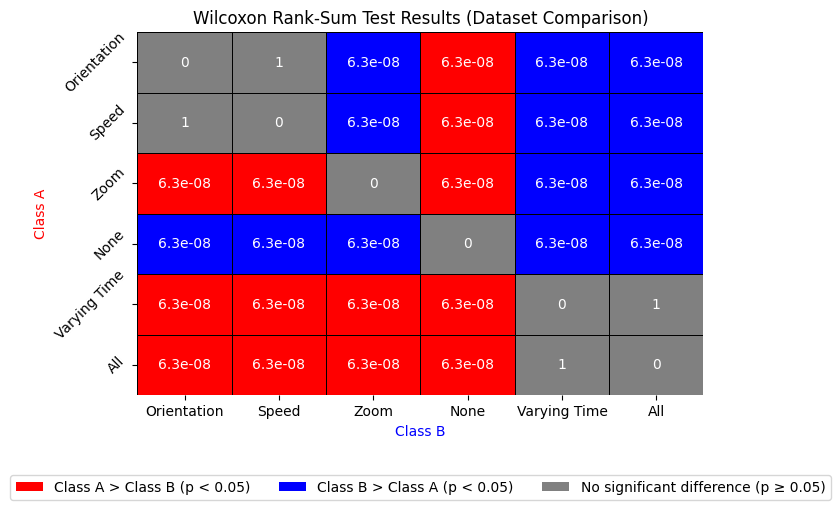

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Filter dataset
df = df[df["Dataset"].isin(["Orientation", "Speed", "Zoom", "None", "Varying Time", "All"])]

# Get unique dataset classes
datasets = df["Dataset"].unique()
num_classes = len(datasets)

# Initialize significance matrices
significance_matrix = np.zeros((num_classes, num_classes))
significance_matrix_ = np.zeros((num_classes, num_classes))

# Compute Wilcoxon rank-sum test for each pair of datasets
for i, class_a in enumerate(datasets):
    for j, class_b in enumerate(datasets):
        if i == j:
            continue  # Skip self-comparisons
        
        # Extract train accuracies for both datasets
        acc_a = df[df["Dataset"] == class_a]["Train"].values
        acc_b = df[df["Dataset"] == class_b]["Train"].values

        # Perform rank-sum test
        stat, p = stats.ranksums(acc_a, acc_b)
        significance_matrix_[i][j] = p  # Store p-value
        
        # Determine significance
        if p < 0.05:
            significance_matrix[i, j] = 1 if stat > 0 else -1  # 1 = Class A is better, -1 = Class B is better
        else:
            significance_matrix[i, j] = 0  # No significant difference

# Define a discrete colormap
cmap = ListedColormap(["blue", "grey", "red"])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(significance_matrix, cmap=cmap, cbar=False, 
            xticklabels=datasets, yticklabels=datasets, 
            linewidths=0.5, linecolor="black", annot=significance_matrix_)
plt.yticks(rotation=45)  # Rotate y-axis labels to 45 degrees
plt.title("Wilcoxon Rank-Sum Test Results (Dataset Comparison)")
plt.xlabel("Class B", color="blue")
plt.ylabel("Class A", color="red")

# Custom legend
legend_elements = [
    Patch(facecolor='red', label='Class A > Class B (p < 0.05)'),
    Patch(facecolor='blue', label='Class B > Class A (p < 0.05)'),
    Patch(facecolor='grey', label='No significant difference (p ≥ 0.05)')
]

# Move legend below the plot
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# Adjust layout to accommodate the legend
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Save and show plot
plt.savefig(path + "/images/ranksum_matrix_augmentation.pdf", bbox_inches="tight")
plt.show()


## validation of robustness

In [3]:
data_all=loaded(t=20,filename="X_data_15.npz")
data_all.applySobel()
data_all.speed_augment(t=4)
data_all.zoom_augment([10,20,30,40])
data_all.orientation_augment()
data_all.shuffle()
data_all.X=data_all.X[0:15000]
data_all.y=data_all.y[0:15000]

data_speed=loaded(t=20,filename="X_data_15.npz")
data_speed.applySobel()
data_speed.zoom_augment([10,20,30,40])
data_speed.orientation_augment()
data_speed.shuffle()
data_speed.X=data_speed.X[0:15000]
data_speed.y=data_speed.y[0:15000]

data_zoom=loaded(t=20,filename="X_data_15.npz")
data_zoom.applySobel()
data_zoom.speed_augment(t=4)
data_zoom.orientation_augment()
data_zoom.shuffle()
data_zoom.X=data_zoom.X[0:15000]
data_zoom.y=data_zoom.y[0:15000]

data_orientation=loaded(t=20,filename="X_data_15.npz")
data_orientation.applySobel()
data_orientation.speed_augment(t=4)
data_orientation.zoom_augment([10,20,30,40])
data_orientation.shuffle()
data_orientation.X=data_orientation.X[0:15000]
data_orientation.y=data_orientation.y[0:15000]

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 135000 
Window size: 4 
Image: (110, 120)
Memory needed: 6.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 45000 
Window size: 20 
Image: (110, 120)
Memory needed: 11.06 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 27000 
Window size: 4 
Image: (110, 120)
Memory needed: 1.33 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [10]:
data_all_only=loaded(t=20,filename="X_data_15.npz")
data_all_only.X=data_all_only.X+np.random.normal(np.mean(data_all_only.X),30,data_all_only.X.shape)
data_all_only.X=data_all_only.X[0:15000]
data_all_only.y=data_all_only.y[0:15000]

data_speed_only=loaded(t=20,filename="X_data_15.npz")
data_speed_only.applySobel()
data_speed_only.speed_augment(t=4)
data_speed_only.shuffle()
data_speed_only.X=data_speed_only.X[0:15000]
data_speed_only.y=data_speed_only.y[0:15000]

data_zoom_only=loaded(t=20,filename="X_data_15.npz")
data_zoom_only.applySobel()
data_zoom_only.zoom_augment([10,20,30,40])
data_zoom_only.shuffle()
data_zoom_only.X=data_zoom_only.X[0:15000]
data_zoom_only.y=data_zoom_only.y[0:15000]

data_orientation_only=loaded(t=20,filename="X_data_15.npz")
data_orientation_only.applySobel()
data_orientation_only.orientation_augment()
data_orientation_only.shuffle()
data_orientation_only.X=data_orientation_only.X[0:15000]
data_orientation_only.y=data_orientation_only.y[0:15000]

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [9]:
datasets=[data_all,data_orientation,data_speed,data_zoom]
test_removed=[data_all_only,data_orientation_only,data_speed_only,data_zoom_only]
T_SIZE=4
EPOCHS=100
#train up model
av=np.zeros((len(datasets),5,3))
for i in range(len(datasets)):
    for j in range(5):
        clear_output(wait=True)
        print(i,j)
        data=datasets[i]
        train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
        model,history=run(train_loader,0,4,num_epochs = EPOCHS)
        print("Commence calculations...")
        tra=calc(model,train_loader)
        tre=calc(model,test_loader)
        print("Results:",tra,tre)
        av[i][j][0]=tra
        av[i][j][1]=tre
        data_=test_removed[i]
        train_loader,test_loader=org_data(data_,(len(data_.X),1,T_SIZE*data_.X.shape[2],data_.X.shape[3]))
        acc=np.average([calc(model,train_loader),calc(model,test_loader)])
        av[i][j][2]=acc

0 0
LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [300/300], Loss: 812.2767
Epoch [11/100], Step [300/300], Loss: 207.7327
Epoch [21/100], Step [300/300], Loss: 58.3284


KeyboardInterrupt: 

LOADED DATASET...
Memory left 23.59 GB
(15000, 4, 110, 120) (15000, 1, 440, 120)
Using 5.9 GB
torch.Size([15000, 1, 440, 120])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Accuracy: 30.11641569653586 %
Accuracy: 30.498983367221093 %
Accuracy on noisy data 0.30307699531878474


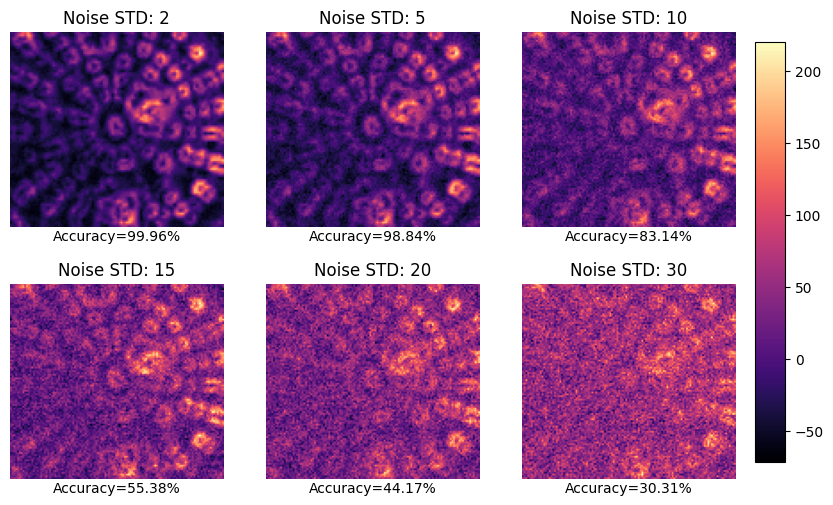

In [9]:
#add noise to data

print(np.mean(data.X),np.std(data.X))

noises=[2,5,10,15,20,30]
fig, axes = plt.subplots(2, 3, figsize=(10, 6))  # 2 rows, 3 columns
fig.subplots_adjust(right=0.85)  # Space for colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Colorbar axes

for i in range(len(noises)):
    clear_output(wait=True)
    row, col = divmod(i, 3)  # Convert index to row and column
    noisy_data=data.X+np.random.normal(np.mean(data.X),noises[i],data.X.shape)
    im = axes[row, col].imshow(noisy_data[0][0],cmap="magma")  # Display in grayscale
    axes[row, col].axis('off')  # Hide axes
    
    
    data_=deepcopy(data)
    data_.X=noisy_data
    train_loader,test_loader=org_data(data_,(len(data_.X),1,T_SIZE*data_.X.shape[2],data_.X.shape[3]))
    acc=np.average([calc(model,train_loader),calc(model,test_loader)])
    
    axes[row, col].text(0.5, -0.01,"Accuracy="+str(round(acc*100,2))+"%",ha='center', va='top', transform=axes[row, col].transAxes)
    axes[row, col].set_title("Noise STD: "+str(noises[i]))
    
    print("Accuracy on noisy data",acc)
fig.colorbar(im, cax=cbar_ax)
#plt.tight_layout()
plt.savefig(path+"/images/augmentation_robustness.pdf")
plt.show()

In [8]:
data=loaded(t=4,filename="X_data_15.npz")
data.applySobel()
data.orientation_augment()
train_loader,test_loader=org_data(data,(len(data.X),1,T_SIZE*data.X.shape[2],data.X.shape[3]))
print("Commence calculations...")
tra=calc(model,train_loader)
tre=calc(model,test_loader)
print("Results:",np.average([tra,tre]))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
LOADED DATASET...
Memory left 23.59 GB
(9000, 4, 110, 120) (9000, 1, 440, 120)
Using 3.54 GB
torch.Size([9000, 1, 440, 120])
torch.Size([9000, 15])
Commence calculations...


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Accuracy: 34.24952431216233 %
Accuracy: 33.22037664574191 %
Results: 0.3373495047895212
